In [12]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from estimation_fct import *
from graph_format import *

# Load model
from model import ModelClass

model = ModelClass() 

par = model.par
sol = model.sol
sim = model.sim


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Prepare data
mean, weights, moments = prepare_data(par)

In [14]:
rows_to_drop = np.arange(40+70+55, 40+70+55+15)
cols_to_drop = np.arange(40+70+55, 40+70+55+15)

mean_drop = np.delete(mean, rows_to_drop, axis=0)

weights_drop = np.delete(weights, rows_to_drop, axis=0)
weights_drop = np.delete(weights_drop, cols_to_drop, axis=1)


In [15]:
var1 = np.mean(mean[:40])
var2 = np.mean(mean[40:110])
var3 = np.mean(mean[110:165])
var4 = np.mean(mean[180:])

n = 205
test_weight = np.zeros((n, n))

# fill only the four blocks with 1/var^2
blocks = [
    (0,    40,  var1),
    (40,  110,  var2),
    (110, 165,  var3),
    (180, 205,  var4)
]

for start, end, v in blocks:
    idx = np.arange(start, end)
    test_weight[idx, idx] = 1.0 / (v**2)


In [16]:
def randomize_theta_init(theta_init, bounds, pct=0.05):
    randomized = []
    for val, (lower, upper) in zip(theta_init, bounds):
        delta = pct * val
        min_val = max(lower, val - delta)
        max_val = min(upper, val + delta)
        randomized_val = np.random.uniform(min_val, max_val)
        randomized.append(randomized_val)
    return np.array(randomized)

# Prepare SMM
theta_names = ("beta", "sigma", "gamma", "mu", "zeta", "beta_1", "gamma_1")

theta_init = np.array([0.9652304682, 1.1438520926, 1.9271780414, 6.2676021454, 8.3247057925, 0.0500512697, 0.0000105423])

# Original bounds
orig_bounds = [(0.0, 1.0),   # beta
               (0.1, 6.0),   # sigma
               (0.1, 10.0),  # gamma
               (0.0, 20.0),  # mu
               (0.0, 15.0),  # zeta
               (0.0, 1.0),
               (0.0, 0.0001)
               ] 

theta_init_scaled = scale_params(theta_init, orig_bounds)

theta_random = randomize_theta_init(theta_init, orig_bounds)
theta_random_scaled = scale_params(theta_random, orig_bounds)

In [ ]:
# Do SMM
objective = lambda theta: obj_func(theta, theta_names, mean_drop, weights_drop, model, orig_bounds, do_print=True)

res = minimize(
    objective, 
    theta_init_scaled,
    method='nelder-mead',
    bounds=[(0,1)] * len(theta_init_scaled),
    tol=1e-6,
    options={"maxiter":2000}
)

theta_final = unscale_params(res.x, orig_bounds)

print(theta_final)

0.9652304682, 1.1438520926, 1.9271780414, 6.2676021454, 8.3247057925, 0.0500512697, 0.0000105423, 
Error = 1.88152, Time = 240.3 seconds
0.9865080084, 1.1438520926, 1.9271780414, 6.2676021454, 8.3247057925, 0.0500512697, 0.0000105423, 
Error = 16.83176, Time = 99.2 seconds
0.9652304682, 1.1960446972, 1.9271780414, 6.2676021454, 8.3247057925, 0.0500512697, 0.0000105423, 
Error = 42.91653, Time = 99.4 seconds
0.9652304682, 1.1438520926, 2.0185369435, 6.2676021454, 8.3247057925, 0.0500512697, 0.0000105423, 
Error = 1.96160, Time = 99.7 seconds
0.9652304682, 1.1438520926, 1.9271780414, 6.5809822527, 8.3247057925, 0.0500512697, 0.0000105423, 
Error = 1.90556, Time = 99.8 seconds
0.9652304682, 1.1438520926, 1.9271780414, 6.2676021454, 8.7409410821, 0.0500512697, 0.0000105423, 
Error = 2.21697, Time = 99.4 seconds
0.9652304682, 1.1438520926, 1.9271780414, 6.2676021454, 8.3247057925, 0.0525538332, 0.0000105423, 
Error = 1.95036, Time = 98.6 seconds
0.9652304682, 1.1438520926, 1.9271780414, 6.2

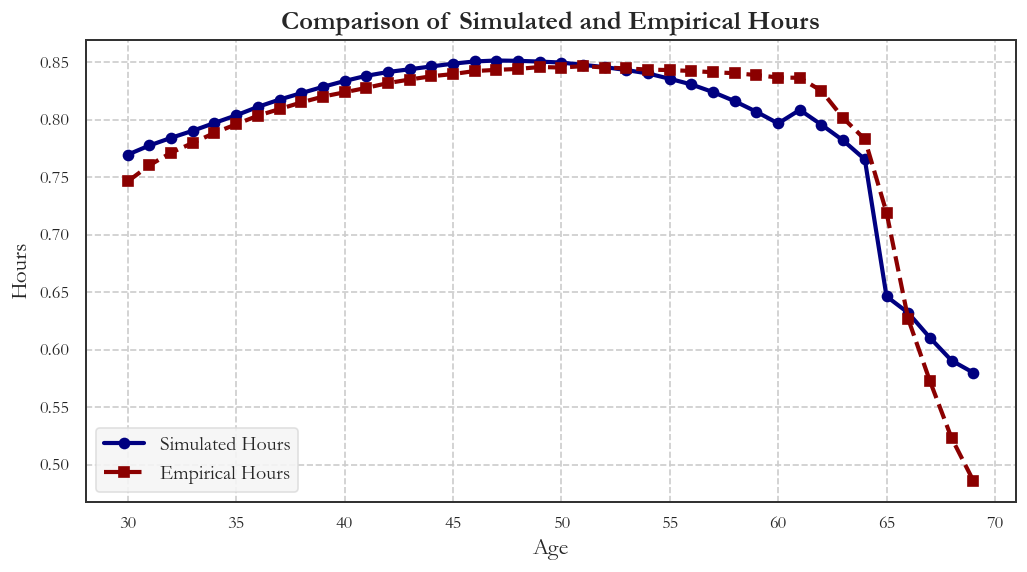

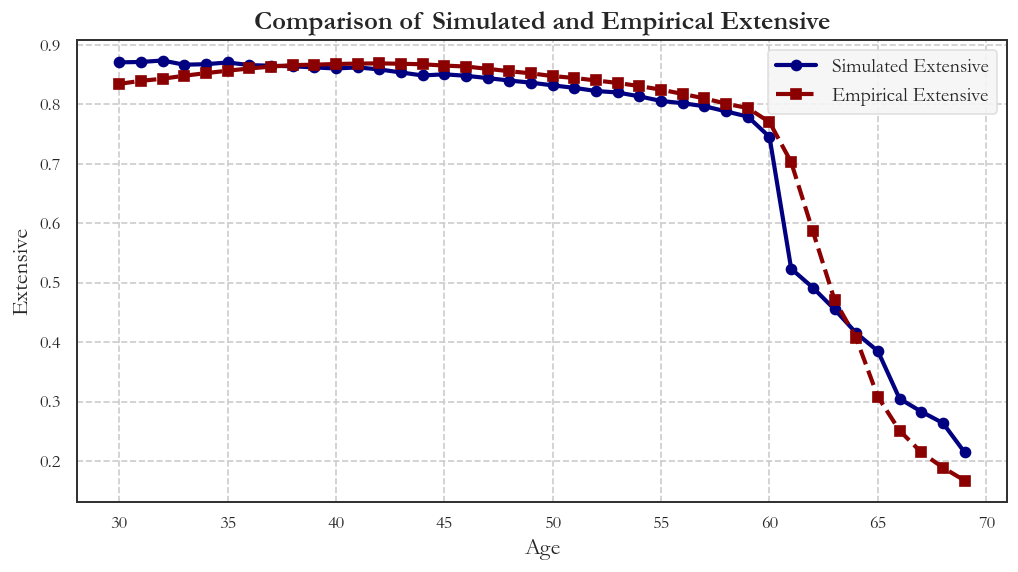

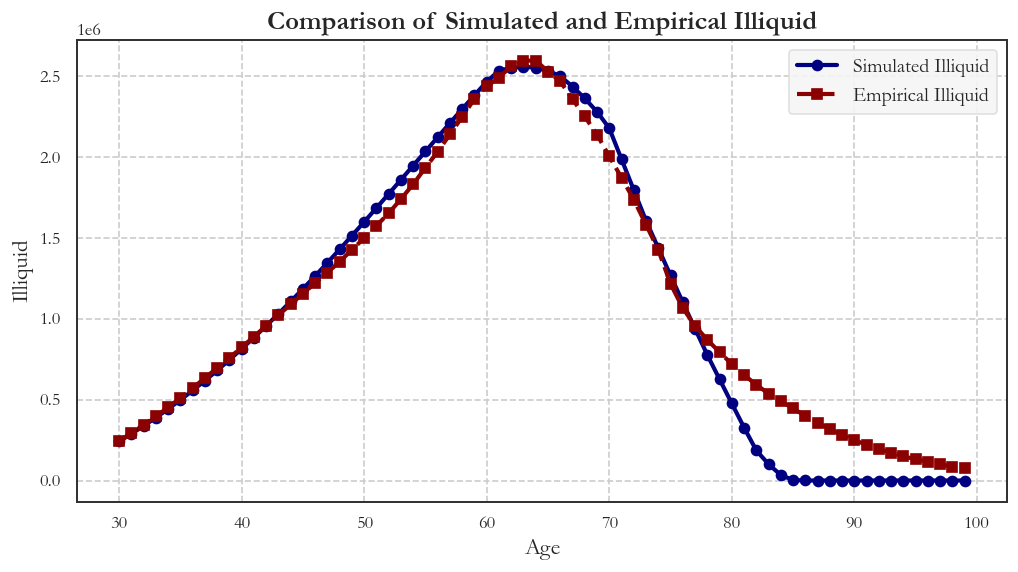

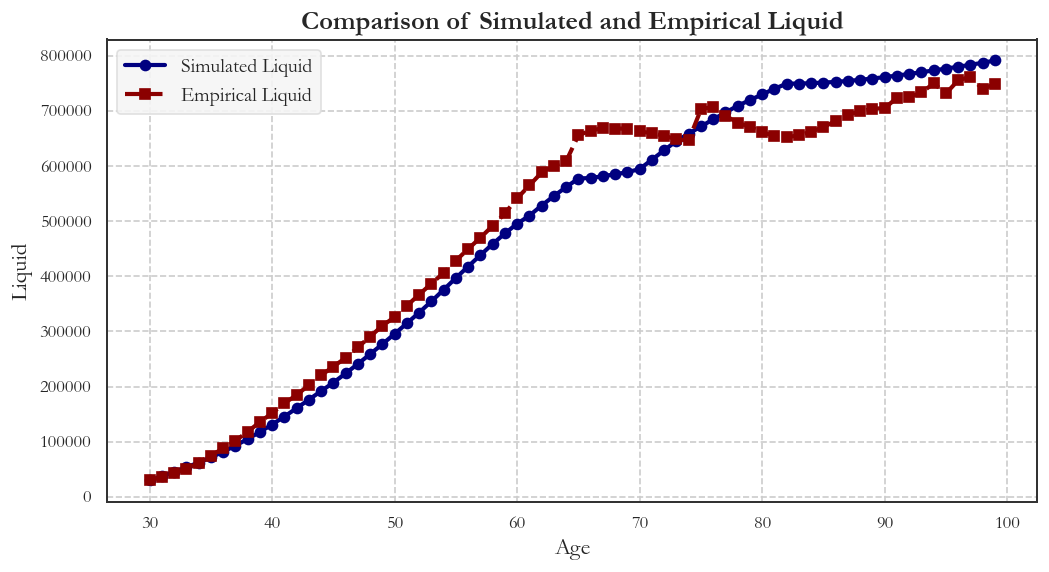

In [ ]:
# Load the model with calibrated values
theta_names = ("beta", "sigma", "gamma", "mu", "zeta", "beta_1", "gamma_1")
# theta_names = ("beta", "zeta")

# # theta_final = theta_init

# theta_final = np.array([0.9652304682, 1.1438520926, 1.9271780414, 6.2676021454, 8.3247057925, 0.0500512697, 0.0000105423])

for i, name in enumerate(theta_names):
    setattr(model.par, name, theta_final[i])

model.solve()
model.simulate()

# plot the graph with calibrated values 
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan),axis=0)[:40], moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:40], moments['extensive']],
    'illiquid': [np.clip(np.mean(model.sim.s, axis=0), 0, None), moments['savings']],
    'liquid': [np.mean(model.sim.a, axis=0), moments['assets']]
}

# Define colors
simulated_color = "navy"  # Dark blue
empirical_color = "darkred"  # Dark red
ci_color = "lightcoral"  # Light red for confidence bands

for key, (simulated, empirical) in a_dict.items():
    plt.figure(figsize=(10, 5))
    
    x_vals = np.arange(len(empirical)) + par.start_age
    
    plt.plot(x_vals, simulated, label=f"Simulated {key.capitalize()}", marker="o", color=simulated_color)
    plt.plot(x_vals, empirical, label=f"Empirical {key.capitalize()}", linestyle="--", marker="s", color=empirical_color)

    # # 99.9% confidence interval
    # ci = std_dev
    # plt.fill_between(x_vals, empirical - ci, empirical + ci, color=ci_color, alpha=0.4, label="Empirical Standard Deviation")

    plt.xlabel("Age")
    plt.ylabel(key.capitalize())
    plt.title(f"Comparison of Simulated and Empirical {key.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# prepare your data dict
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan), axis=0)[:40],
              moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:40],
                  moments['extensive']],
    'liquid': [np.mean(model.sim.a, axis=0),
               moments['assets']]
}


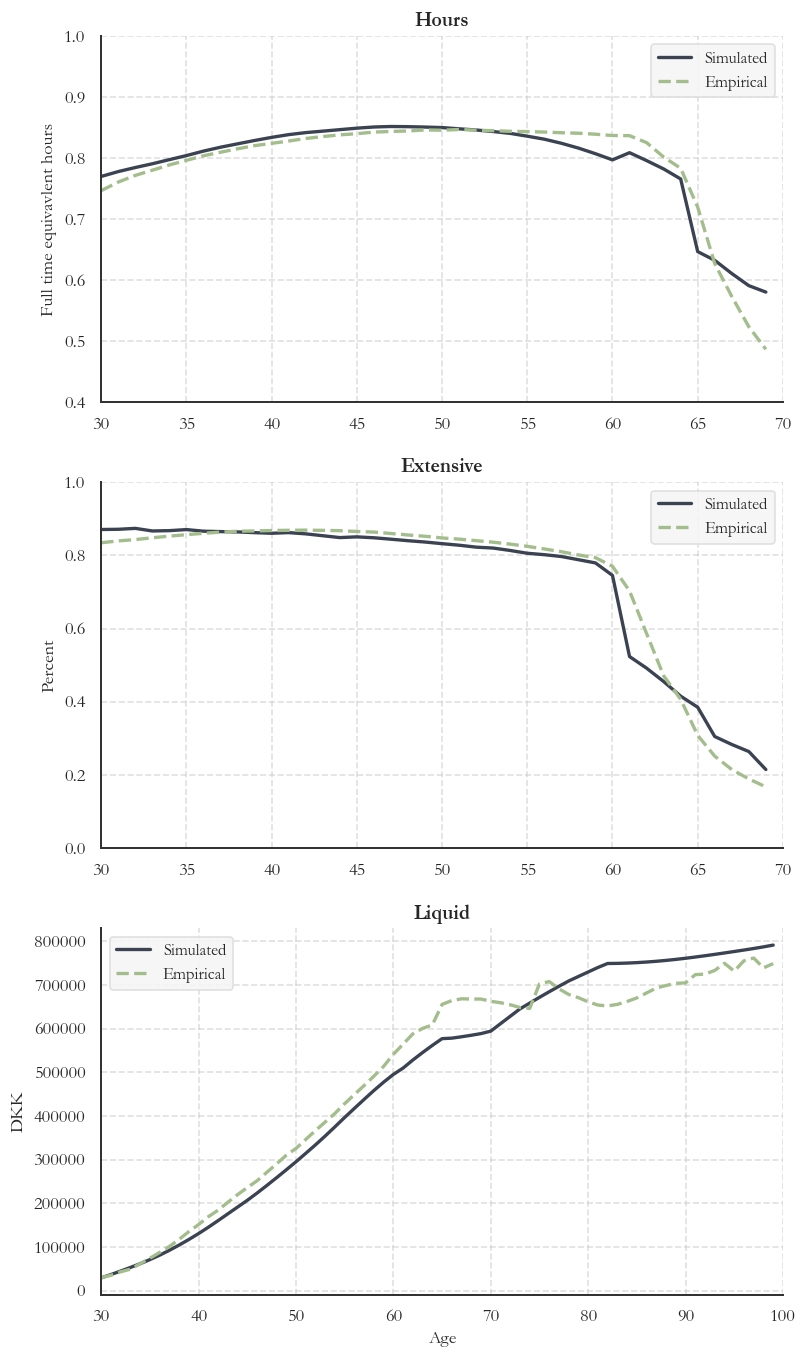

In [ ]:
plot_model_vs_data_grid(a_dict, title="", save_title="in_sample_fit.png")


In [ ]:
means_data = pd.read_csv("Data/mean_matrix.csv")

b_dict = {
    'illiquid': [np.clip(np.clip(np.mean(model.sim.s, axis=0), 0, None) / 1_000_000, 0, None),
                 moments['savings'] / 1_000_000]  ,
    'wages':    [np.nanmean(np.where(model.sim.ex==1, model.sim.w, np.nan)[:, :31] , axis=0),
                 means_data[means_data["alder"] <= 60]["hourly_salary_plsats_Mean"].to_numpy() * 1924]
        }

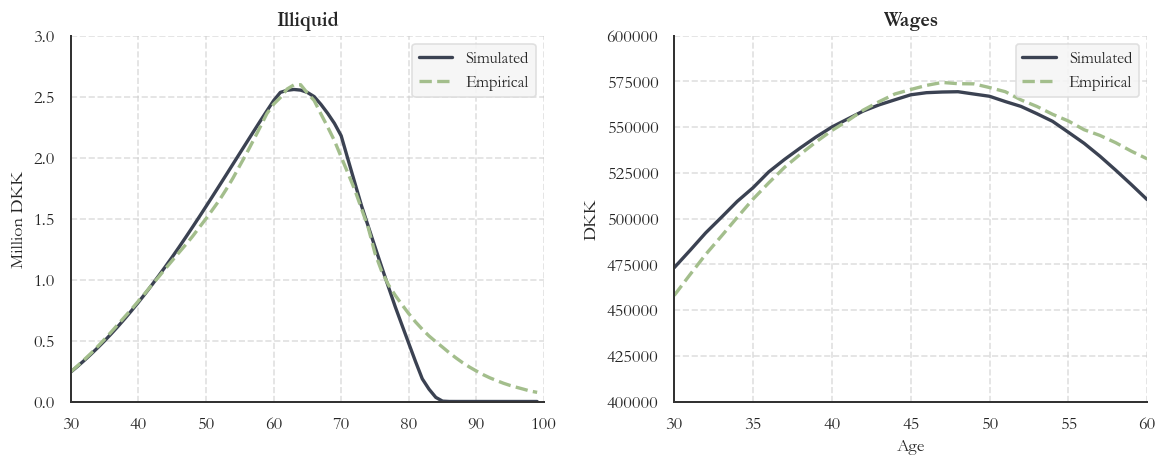

In [ ]:
plot_model_vs_data_grid_oos(b_dict, title="", save_title="out_of_sample_fit.png")
